# EDA

EDA prior to data cleaning and feature engineering/pruning.

In [295]:
# Import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import geopandas as gpd 
import contextily as ctx
from shapely.geometry import Point 

%matplotlib inline

In [296]:
# Set max display options so that I can see everything I need to see
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 200)

## Importing Dataset

The dataset has been split into training and test sets on the DrivenData website and will be using that split later on during modelling. For EDA purposes I will **not** be combining the train and test features to prevent data leakage and biased analysis. 

### Training data

In [297]:
# Training data features
df_features = pd.read_csv('../data/raw/training_set_values.csv')
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [298]:
# Training data targets
df_target = pd.read_csv('../data/raw/training_set_labels.csv')
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.3+ KB


In [299]:
# Combined dataframe of features and target variables
df = pd.merge(df_features, df_target, on='id')

In [300]:
# Renaming 'status_group' to 'target'
df.rename(columns={'status_group': 'target'}, inplace='True')

In [301]:
# Export full training dataset as csv
df.to_csv('../data/raw/raw_training_set_full.csv', index=False)

### Test data

While I won't be using this test data in EDA I will be performing the same data type conversions 0 to NaN conversions so that I can do the same data cleaning for both training and test data.

In [302]:
df_test = pd.read_csv('../data/raw/test_set_values.csv')

---

## Examining Target Variable

In [303]:
# Checking class balance
df['target'].value_counts()

target
functional                 32259
non functional             22824
functional needs repair     4317
Name: count, dtype: int64

/var/folders/qw/rb7_t46j2zzdbl34bgb2vjg40000gn/T/ipykernel_81982/1689945861.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=target_counts.index, x=target_counts.values, palette='Dark2')


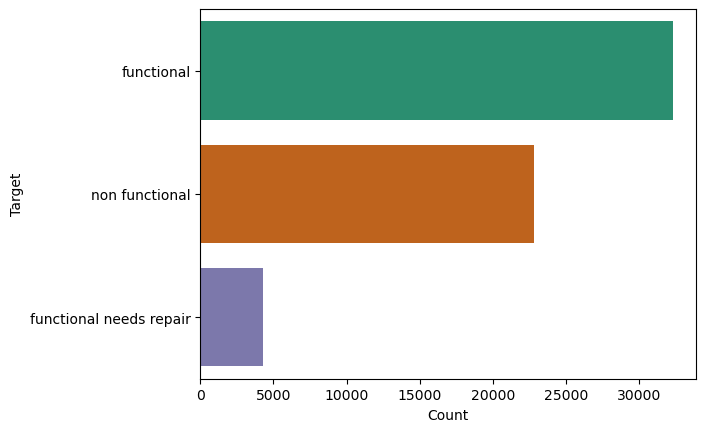

In [304]:
target_counts = df['target'].value_counts()
ax = sns.barplot(y=target_counts.index, x=target_counts.values, palette='Dark2')
ax.set_ylabel('Target')
ax.set_xlabel('Count')

plt.savefig('../images/target_barplot.png', dpi=300, bbox_inches='tight')

There is a clear **class imbalance** with 'functional needs repair' recorded at a way lower frequency in the dataset. There are three paths I can take here. The first and easiest to execute is simply treating 'functional needs repair' as an irrelevant target and dropping it completely from the dataset.

The second is investigating whether the smallest class here is similar enough to one of the larger classes and merge it with the class it is most similar with. For example, perhaps 'funcional needs repair' means that a water pump is functional enough that it could be merged into the 'functional' target class. 

The third option is to employ some of the myriad techniques that deal with imbalanced classes in ML. I could use SMOTE or oversampling/undersampling with the imblearn library. 

### Plotting Targets on a Map of Tanzania

/var/folders/qw/rb7_t46j2zzdbl34bgb2vjg40000gn/T/ipykernel_81982/81144794.py:14: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  gdf_in_tanzania = gpd.sjoin(gdf, tanzania, how="inner", predicate="within")


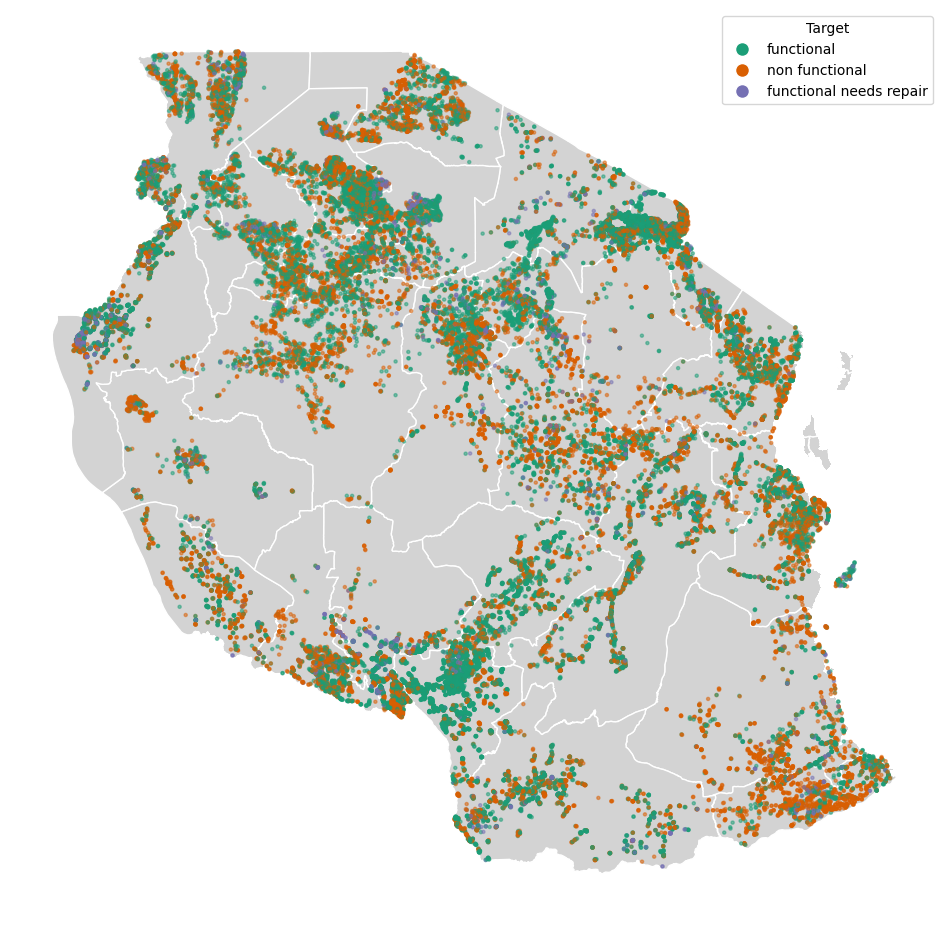

In [305]:
# Plotting training set target variables on map of Tanzania

# Load Tanzania shapefile (country boundary)
tanzania = gpd.read_file("../images/shapefiles/gadm41_TZA_1.shp")

# Load data (coordinates in the dataset)
coordinates_df = df[['longitude', 'latitude', 'target']].dropna()

# Create GeoDataFrame from coordinates
geometry = [Point(xy) for xy in zip(coordinates_df['longitude'], coordinates_df['latitude'])]
gdf = gpd.GeoDataFrame(coordinates_df, geometry=geometry, crs="EPSG:4326")  # Set CRS to WGS 84

# Filter points that are within Tanzania's boundary
gdf_in_tanzania = gpd.sjoin(gdf, tanzania, how="inner", predicate="within")

# Get the unique categories from the 'target' column
unique_categories = gdf_in_tanzania['target'].unique()

# Create a seaborn color palette
palette = sns.color_palette('Dark2', n_colors=len(unique_categories))

# Create a dictionary to map each category to a color
color_dict = dict(zip(unique_categories, palette))

# Map the colors to the 'target' column in the GeoDataFrame
gdf_in_tanzania['color'] = gdf_in_tanzania['target'].map(color_dict)

# Plot Tanzania's boundary and data points with the mapped colors
fig, ax = plt.subplots(figsize=(12, 12))

# Plot Tanzania shape
tanzania.plot(ax=ax, color="lightgray", edgecolor='white')

# Plot points using the manually mapped colors
gdf_in_tanzania.plot(ax=ax, color=gdf_in_tanzania['color'], markersize=5, alpha=0.5)

# Create a custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[cat], markersize=10, label=cat)
           for cat in unique_categories]
ax.legend(handles=handles, title="Target", bbox_to_anchor=(1, 1))

# Remove axis for a cleaner map
ax.set_axis_off()

plt.savefig('../images/target_scatterplot.png', dpi=300, bbox_inches='tight')
plt.show()

In [306]:
# Extracting the hex codes from the seaborn color palette Dark2 for later use in visualizations
palette = sns.color_palette("Dark2")
hex_codes = [f'#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}' for r, g, b in palette]
print(hex_codes)

['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02', '#a6761d', '#666666']


---

## Examining Features

### Custom Functions for EDA

The custom functions used in this project are all are borrowed directly from GitHub user [BrendaLoznik](https://github.com/BrendaLoznik). These functions are excellent for diving deeper into the features in my dataset, particularly so because of the lack of domain knowledge on my part for this topic. Below is a list of these functions but for a detailed look at them see utils.py in the src folder.

- numerical_dqr
- categorical_dqr
- datetime_dqr
- duplicate_checker
- distribution_checker
- kdeplotter
- countplotter

In [307]:
# Importing the custom functions
import sys
import os 

sys.path.append(os.path.abspath('../src'))

from utils import *

The following information on the features is provided by DrivenData:

- *amount_tsh* - Total static head (amount water available to waterpoint)
- *date_recorded* - The date the row was entered
- *funder* - Who funded the well
- *gps_height* - Altitude of the well
- *installer* - Organization that installed the well
- *longitude* - GPS coordinate
- *latitude* - GPS coordinate
- *wpt_name* - Name of the waterpoint if there is one
- *num_private* -
- *basin* - Geographic water basin
- *subvillage* - Geographic location
- *region* - Geographic location
- *region_code* - Geographic location (coded)
- *district_code* - Geographic location (coded)
- *lga* - Geographic location
- *ward* - Geographic location
- *population* - Population around the well
- *public_meeting* - True/False
- *recorded_by* - Group entering this row of data
- *scheme_management* - Who operates the waterpoint
- *scheme_name* - Who operates the waterpoint
- *permit* - If the waterpoint is permitted
- *construction_year* - Year the waterpoint was constructed
- *extraction_type* - The kind of extraction the waterpoint uses
- *extraction_type_group* - The kind of extraction the waterpoint uses
- *extraction_type_class* - The kind of extraction the waterpoint uses
- *management* - How the waterpoint is managed
- *management_group* - How the waterpoint is managed
- *payment* - What the water costs
- *payment_type* - What the water costs
- *water_quality* - The quality of the water
- *quality_group* - The quality of the water
- *quantity* - The quantity of water
- *quantity_group* - The quantity of water
- *source* - The source of the water
- *source_type* - The source of the water
- *source_class* - The source of the water
- *waterpoint_type* - The kind of waterpoint
- *waterpoint_type_group* - The kind of waterpoint

Not the best descriptions but we work with what we got, right? 

'num_private' has no description and some of the other features have the same descriptions. Perhaps taking a closer look at the data in these features will shed more light on what they are.

In [308]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

If we disregard the obvious columns 'id' which is just a unique index for each record and 'target' - our target variable - there are 39 features in the dataset. At a quick glance there are some missing values here and there with the most in 'scheme_name'. It may be that there is more missing data that are masked by a 0. First, I'll check for duplicates.

### Duplicate check

In [309]:
# Duplicate check - looks like there are no duplicates!
duplicate_checker(df)

Number of duplicates: 0
Total number of records: 59400
Percentage duplicated: 0.0


### Numerical features overview

In [310]:
# Using the numerical_dqr function to get an overview of numerical features
numerical_dqr = numerical_dqr(df)
numerical_dqr

,Data Type,Records,Unique Values,Missing Values,Missing %,Mean Value,Minimum Value,1st Quartile,Median,3rd Quartile,Maximum Value
id,int64,59400,59400,0,0.0,37115.1,0.0,18519.8,37061.5,55656.5,74247.0
amount_tsh,float64,59400,98,0,0.0,317.7,0.0,0.0,0.0,20.0,350000.0
gps_height,int64,59400,2428,0,0.0,668.3,-90.0,0.0,369.0,1319.2,2770.0
longitude,float64,59400,57516,0,0.0,34.1,0.0,33.1,34.9,37.2,40.3
latitude,float64,59400,57517,0,0.0,-5.7,-11.6,-8.5,-5.0,-3.3,-0.0
num_private,int64,59400,65,0,0.0,0.5,0.0,0.0,0.0,0.0,1776.0
region_code,int64,59400,27,0,0.0,15.3,1.0,5.0,12.0,17.0,99.0
district_code,int64,59400,20,0,0.0,5.6,0.0,2.0,3.0,5.0,80.0
population,int64,59400,1049,0,0.0,179.9,0.0,0.0,25.0,215.0,30500.0
construction_year,int64,59400,55,0,0.0,1300.7,0.0,0.0,1986.0,2004.0,2013.0


This report tells us a few interesting things:

- As mentioned before, 'id' is just a unique identifier for each record and thus can be dropped during data cleaning. 
- There are no null values, but this does not necessarily mean there are no missing values at all, some of the 0's might just be set to 0 because there was no recording.
- 'amount_tsh' and 'num_private' contain a large quantity of 0's seeing as their medians are 0
- Tanzania has no longitude 0
- There are quite a few records with population 0, this could be due there being no data on population for certain districts/wards/subvillages

Features like 'region_code' and 'district_code' are actually categoricals and should be treated as such.

In [311]:
# Converting features that are the wrong data type
df[['region_code', 'district_code', 'id']] = df[['region_code', 'district_code', 'id']].astype('object') # Training set

In [312]:
# The same for the test set
df_test[['region_code', 'district_code', 'id']] = df_test[['region_code', 'district_code', 'id']].astype('object') # Test set

### Categorical features overview

In [313]:
# Using the categorical_dqr function on my categorical features
categorical_dqr = categorical_dqr(df)
categorical_dqr

,Data Type,Records,Unique Values,Missing Values,Missing %,Mode,Mode freq.,Mode %
id,object,59400,59400,0,0.0,0,1,0.0
date_recorded,object,59400,356,0,0.0,2011-03-15,572,1.0
funder,object,55763,1896,3637,6.1,Government Of Tanzania,9084,16.3
installer,object,55745,2145,3655,6.2,DWE,17402,31.2
wpt_name,object,59398,37399,2,0.0,none,3563,6.0
basin,object,59400,9,0,0.0,Lake Victoria,10248,17.3
subvillage,object,59029,19287,371,0.6,Madukani,508,0.9
region,object,59400,21,0,0.0,Iringa,5294,8.9
region_code,object,59400,27,0,0.0,11,5300,8.9
district_code,object,59400,20,0,0.0,1,12203,20.5


This overview provides some good insight into the categorical features:

- Some of the categoricals ('installer', 'funder', 'wpt_name', 'ward', 'scheme_name') have a high number of unique values, making them unsuitable - in their current form - for the kind of modelling I'll be doing. I'll explore reducing the dimensionality of these features in feature engineering or consider dropping them completely
- 'recorded_by' has only one value, thus can be dropped as an irrelevant feature 
- 'public_meeting' and 'permit' are booleans
- Features like 'management_group', 'water_quality', 'quality_group', and 'source_class' are dominated by their mode values
- Features with names starting with the same word are most likely related with some of them being more granular versions of a "main" category
- Seven of the features have missing values according to this table, but there might be more disguised as zeros in the data, more on this in data cleaning

---

## Features deep dive

I'll take a closer look at each of the features in the data. This will provide more clarity on which features I deem important and necessary for modelling and at the same time I'll get a better understanding for what some of them mean. I will be going through them in the column order of the dataset for the most part.

In [314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  object 
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  object 
 14  district_code          59400 non-null  object 
 15  lg

### **amount_tsh**

The description given by the dataset provider is "amount of water available to waterpoint" while [pumpfundamentals.com](https://www.pumpfundamentals.com/) defines total static head (TSH) as "the difference between the discharge static head and the suction static head, or the difference in elevation at the outlet including the pressure head at the outlet, and the elvation at the inlet including the pressure head at the inlet". In simpler terms, it is basically how high the pump needs to move water from one place to another. For this dataset, however, I will assume the definition given by DrivenData is the intented one. 

In [315]:
numerical_dqr.loc[['amount_tsh']]

,Data Type,Records,Unique Values,Missing Values,Missing %,Mean Value,Minimum Value,1st Quartile,Median,3rd Quartile,Maximum Value
amount_tsh,float64,59400,98,0,0.0,317.7,0.0,0.0,0.0,20.0,350000.0


In [316]:
# Checking the 10 most common values in 'amount_tsh'
df['amount_tsh'].value_counts().head(10)

amount_tsh
0.0       41639
500.0      3102
50.0       2472
1000.0     1488
20.0       1463
200.0      1220
100.0       816
10.0        806
30.0        743
2000.0      704
Name: count, dtype: int64

In [317]:
# Same as above but normalized 
df['amount_tsh'].value_counts(normalize=True).head(10)

amount_tsh
0.0       0.700993
500.0     0.052222
50.0      0.041616
1000.0    0.025051
20.0      0.024630
200.0     0.020539
100.0     0.013737
10.0      0.013569
30.0      0.012508
2000.0    0.011852
Name: proportion, dtype: float64

Just over 70% of the values in this feature are 0. Intuitively it does not make sense for a water pump to be considered 'functional' if there is no water available to it unless functionality refers only to whether a water pump is functioning mechanically. The data, however, has plenty of entries where 'amount_tsh' is 0 and the water pump is still 'functional'.

In [318]:
# Records where 'amount_tsh' = 0 and water pump is functional
df[['amount_tsh', 'target']].loc[(df['amount_tsh'] == 0) & (df['target'] == 'functional')]

,amount_tsh,target
1,0.0,functional
4,0.0,functional
9,0.0,functional
10,0.0,functional
12,0.0,functional
...,...,...
59390,0.0,functional
59393,0.0,functional
59397,0.0,functional
59398,0.0,functional


In [319]:
# Let's see if there is any insight on the target variable when amount_tsh is 0 compared to when it isn't
temp = df.copy()
temp['amount_tsh_missing'] = np.where( temp['amount_tsh']!=0.0, 1, 0) # if amount_tsh != 0, then 1, otherwise 0

# Visualize the distribution of the target variable 'status_group' among 'amount_tsh'
distribution_checker(temp, 'amount_tsh_missing')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
amount_tsh_missing,,,,,
0,41639.0,70.1,47.3,45.4,7.3
1,17761.0,29.9,70.7,22.2,7.1


When amount_tsh=0 (amount_tsh_missing=1 in the above table) there is a larger fraction of non-functional pumps and smaller fraction of functional ones.

Let's take a look at how 'amount_tsh' compares with 'quantity'. The 'quantity' feature is described as "the quantity of water" which intuitively seems as if it should align with 'amount_tsh'. Without knowing further details on how these two categories were measured, I assume them to be fairly similar in what they represent.

In [320]:
# Entries that have '0' amount_tsh but 'enough' quantity
df[['amount_tsh', 'quantity']].loc[(df['amount_tsh'] == 0) & (df['quantity'] == 'enough')]

,amount_tsh,quantity
6,0.0,enough
7,0.0,enough
9,0.0,enough
10,0.0,enough
12,0.0,enough
...,...,...
59389,0.0,enough
59391,0.0,enough
59392,0.0,enough
59397,0.0,enough


Interesting, these cases where amount_tsh is 0 are most likely just missing values. Imputing these will be challenging so perhaps the best option is to drop the feature completely. Since I've already looked into quantity let's take a look at 'quantity' and 'quantity_group' next.

### **quantity and quantity_group**

In [321]:
# Are these two categories even different from one another?
categorical_dqr.loc[['quantity', 'quantity_group']]

,Data Type,Records,Unique Values,Missing Values,Missing %,Mode,Mode freq.,Mode %
quantity,object,59400,5,0,0.0,enough,33186,55.9
quantity_group,object,59400,5,0,0.0,enough,33186,55.9


In [322]:
# Seems like 'quantity' and 'quantity_group' contain the exact same values
(df['quantity'] == df['quantity_group']).value_counts()

True    59400
Name: count, dtype: int64

In [323]:
df['quantity'].value_counts()

quantity
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: count, dtype: int64

Unknowns are missing values.

Since these two features contain the same values, I'll be dropping one in the data cleaning phase. 

Next up, 'date_recorded'.

### **date_recorded**

In [324]:
# Convert 'date_recorded' to datetime
df['date_recorded'] = pd.to_datetime(df['date_recorded'])

In [325]:
datetime_dqr = datetime_dqr(df)
datetime_dqr

,Data Type,Records,Unique Values,Missing Values,Missing %,Mean Value,Minimum Value,1st Quartile,Median,3rd Quartile,Maximum Value
date_recorded,datetime64[ns],59400,356,0,0.0,2012-03-29,2002-10-14,2011-04-01,2012-10-10,2013-02-09,2013-12-03


In [326]:
# Creating a temprary feature 'year_recorded' from 'date_recorded' to see year distribution
temp = df.copy()
temp['year_recorded'] = temp['date_recorded'].dt.year

# Visualizing the distribution of the target variable 'status_group' among 'year_recorded'
distribution_checker(temp, 'year_recorded')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
year_recorded,,,,,
2002,1.0,0.0,100.0,0.0,0.0
2004,30.0,0.1,33.3,63.3,3.3
2011,28674.0,48.3,56.6,37.1,6.3
2012,6424.0,10.8,48.7,45.7,5.6
2013,24271.0,40.9,53.2,38.0,8.8


Most of the recordings were made between 2011 and 2013. At a quick glance there is no significant difference in water pump functionality between years recorded. 

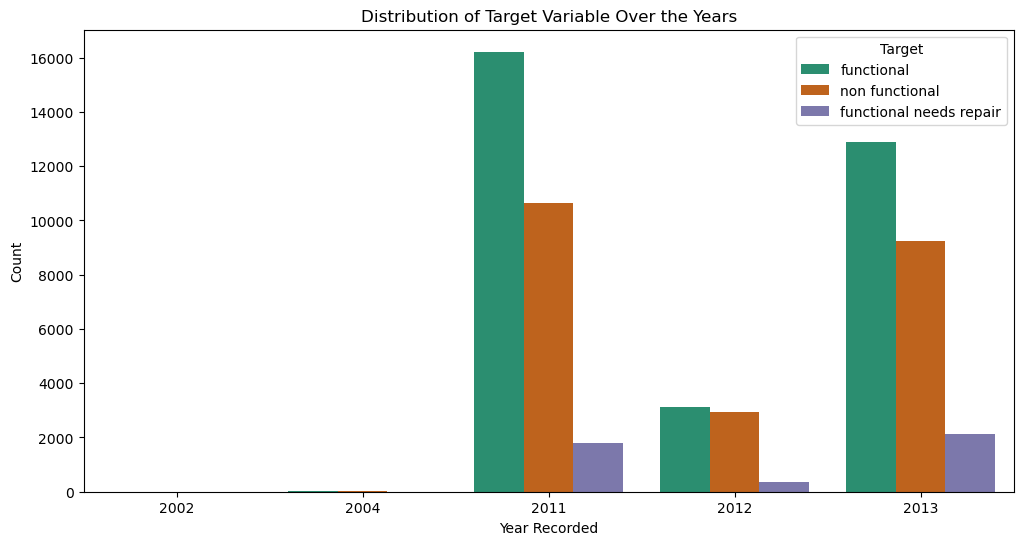

In [327]:
# Plotting the distribution_checker table for 'year_recorded'
plt.figure(figsize=(12, 6))
sns.countplot(data=temp, x='year_recorded', hue='target', palette='Dark2')
plt.title('Distribution of Target Variable Over the Years')
plt.xlabel('Year Recorded')
plt.ylabel('Count')
plt.legend(title='Target')
plt.show()

How about the time of year - specifically month - when recordings were made?

In [328]:
# Create a temporary feature 'month_recorded' from 'date_recorded' to see month distribution
temp['month_recorded'] = temp['date_recorded'].dt.month

# Visualizing the distribution of the target variable 'status_group' among 'month_recorded'
month_recorded = distribution_checker(temp, 'month_recorded')
month_recorded

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
month_recorded,,,,,
1,6354.0,10.7,41.1,46.2,12.7
2,12402.0,20.9,55.2,37.3,7.5
3,17936.0,30.2,61.7,33.3,5.0
4,3970.0,6.7,51.6,37.3,11.0
5,336.0,0.6,60.1,36.9,3.0
6,346.0,0.6,78.0,19.4,2.6
7,6928.0,11.7,50.2,41.9,7.9
8,3364.0,5.7,51.1,41.4,7.5
9,328.0,0.6,65.2,31.7,3.0


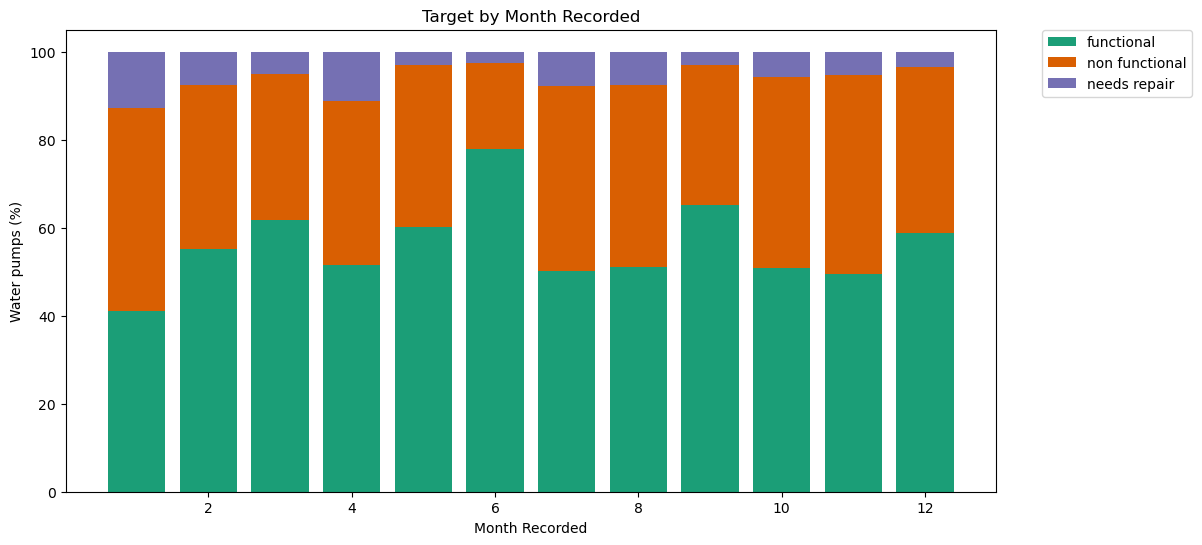

In [329]:
# Visualizing the percentage distribution of the target variable 'target' among 'month_recorded'
fig, ax = plt.subplots(figsize=(12, 6))
labels = temp['month_recorded'].sort_values().unique()
ax.bar(labels, month_recorded['perc_functional'], label = 'functional', color=hex_codes[0])
ax.bar (labels, month_recorded['perc_non_functional'], label = 'non functional', bottom = month_recorded['perc_functional'], color=hex_codes[1])
ax.bar(labels, month_recorded['perc_functional_needs_repair'], label = 'needs repair', bottom = month_recorded['perc_functional'] + month_recorded['perc_non_functional'], color=hex_codes[2])
ax.set_title('Target by Month Recorded')
ax.set_ylabel('Water pumps (%)')
ax.set_xlabel('Month Recorded')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Rainy seasons in Tanzania are usually mid-March to May and November to mid-January while the dry season is usually May to October. Perhaps that is why most measurements are taken at the beginning of the year. There doesn't seem to be a clear effect of month recorded on pump functionality. Since I'm already looking at years I'll take a look at construction year next.

### **construction_year**

In [330]:
numerical_dqr.loc[['construction_year']]

,Data Type,Records,Unique Values,Missing Values,Missing %,Mean Value,Minimum Value,1st Quartile,Median,3rd Quartile,Maximum Value
construction_year,int64,59400,55,0,0.0,1300.7,0.0,0.0,1986.0,2004.0,2013.0


In [331]:
# Distribution of target variable among 'construction_year' in table format
distribution_checker(temp, 'construction_year')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
construction_year,,,,,
0,20709.0,34.9,51.0,40.4,8.6
1960,102.0,0.2,23.5,70.6,5.9
1961,21.0,0.0,9.5,76.2,14.3
1962,30.0,0.1,23.3,73.3,3.3
1963,85.0,0.1,36.5,56.5,7.1
1964,40.0,0.1,17.5,80.0,2.5
1965,19.0,0.0,57.9,36.8,5.3
1966,17.0,0.0,35.3,64.7,0.0
1967,88.0,0.1,35.2,45.5,19.3


Nearly 35% of the water pumps in our data have no construction year. This poses an interesting challenge. To impute or not to impute? Regardless, I'll replace all the 0's that are actually NaN's in the data with NaN and deal with them in data cleaning.

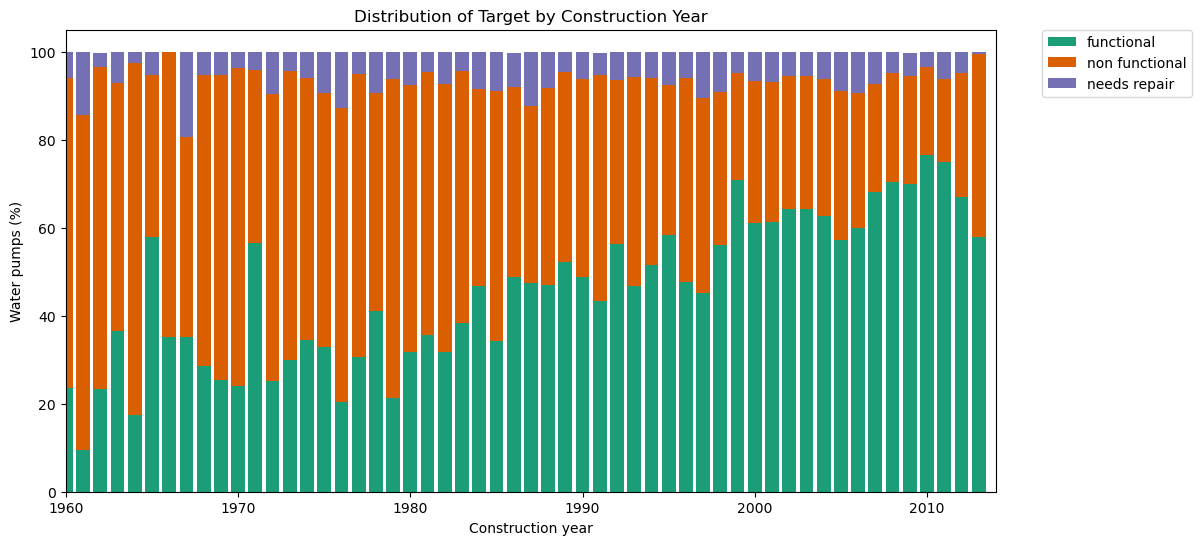

In [332]:
# Plotting the distribution of the target variable 'target' among 'construction_year'
fig, ax = plt.subplots(figsize=(12,6))
construction = distribution_checker(df, 'construction_year')
labels = df['construction_year'].sort_values().unique()
ax.bar(labels, construction['perc_functional'], label='functional', color = hex_codes[0])
ax.bar (labels, construction['perc_non_functional'], label='non functional', bottom=construction['perc_functional'], color=hex_codes[1])
ax.bar(labels, construction['perc_functional_needs_repair'], label='needs repair', bottom=construction['perc_functional'] + construction['perc_non_functional'], color=hex_codes[2])
ax.set(title='Distribution of Target by Construction Year', xlabel='Construction year', ylabel='Water pumps (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim([1960,2014])
plt.show()

Older water pumps seem to have a higher fraction of non-functional status while the opposite is true for the fraction of functional water pumps which makes sense intuitively. It could useful to build a water pump age feature (year_recorded - construction_year) for modelling purposes later on.

In [333]:
# Replace '0' values in 'construction_year' with 'np.nan'
df['construction_year'] = df['construction_year'].replace(0, np.nan)

In [334]:
# Same operation for the test set
df_test['construction_year'] = df_test['construction_year'].replace(0, np.nan)

### **funder and installer**

In [335]:
categorical_dqr.loc[['funder', 'installer']]

,Data Type,Records,Unique Values,Missing Values,Missing %,Mode,Mode freq.,Mode %
funder,object,55763,1896,3637,6.1,Government Of Tanzania,9084,16.3
installer,object,55745,2145,3655,6.2,DWE,17402,31.2


Both of these categories have a high number of unique values so an effective way to encode these categoricals will be needed if I want to use them in my models.

In [336]:
# Distribtion of target variable among 'funder' in table format
funder = distribution_checker(df, 'funder')
funder = funder.sort_values('nr_pumps', ascending=False)
funder.head(10)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
funder,,,,,
Government Of Tanzania,9084.0,16.3,41.0,51.3,7.7
Danida,3114.0,5.6,55.0,39.9,5.1
Hesawa,2202.0,3.9,42.5,47.0,10.5
Rwssp,1374.0,2.5,58.6,33.5,7.9
World Bank,1349.0,2.4,40.4,52.4,7.2
Kkkt,1287.0,2.3,56.2,38.7,5.1
World Vision,1246.0,2.2,59.6,29.9,10.5
Unicef,1057.0,1.9,56.8,33.9,9.4
Tasaf,877.0,1.6,56.2,36.5,7.3


In [337]:
# Distribtion of target variable among 'installer' in table format
installer = distribution_checker(df, 'installer')
installer = installer.sort_values('nr_pumps', ascending=False)
installer.head(10)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
installer,,,,,
DWE,17402.0,31.2,54.2,36.5,9.3
Government,1825.0,3.3,29.3,56.7,14.0
RWE,1206.0,2.2,25.2,63.4,11.4
Commu,1060.0,1.9,68.3,28.7,3.0
DANIDA,1050.0,1.9,51.6,40.5,7.9
KKKT,898.0,1.6,47.0,46.1,6.9
Hesawa,840.0,1.5,56.5,41.4,2.0
0,777.0,1.4,57.3,42.3,0.4
TCRS,707.0,1.3,41.0,53.0,5.9


There is some variance in water pump functionality among the different funders and installers.

### **gps_height, longitude, and latitude**

In [338]:
numerical_dqr.loc[['gps_height', 'longitude', 'latitude']]

,Data Type,Records,Unique Values,Missing Values,Missing %,Mean Value,Minimum Value,1st Quartile,Median,3rd Quartile,Maximum Value
gps_height,int64,59400,2428,0,0.0,668.3,-90.0,0.0,369.0,1319.2,2770.0
longitude,float64,59400,57516,0,0.0,34.1,0.0,33.1,34.9,37.2,40.3
latitude,float64,59400,57517,0,0.0,-5.7,-11.6,-8.5,-5.0,-3.3,-0.0


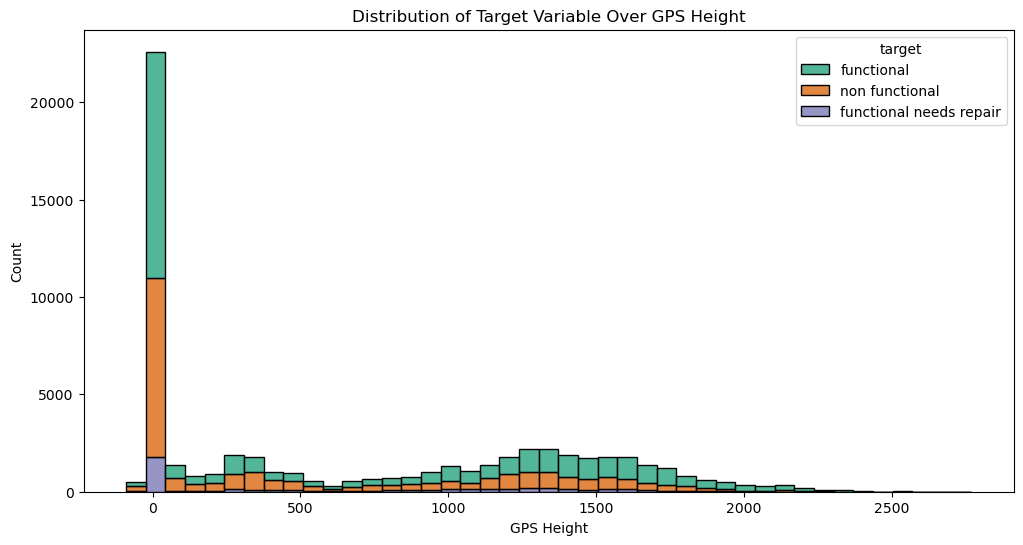

In [339]:
# Countplot of 'gps_height' with 'target' as hue
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='gps_height', hue='target', palette='Dark2', multiple='stack')
plt.title('Distribution of Target Variable Over GPS Height')
plt.xlabel('GPS Height')
plt.ylabel('Count')
plt.show()

Seems like most of the water pumps are located at sea level. The other possibility is that some if not most of the zeroes are simply missing values. 

In [340]:
# Replace '0' values in 'gps_height' with 'np.nan'
df['gps_height'] = df['gps_height'].replace(0, np.nan)

In [341]:
# Same operation for the test set
df_test['gps_height'] = df_test['gps_height'].replace(0, np.nan)

In [342]:
# Longitude and latitude
numerical_dqr.loc[['longitude', 'latitude']]

,Data Type,Records,Unique Values,Missing Values,Missing %,Mean Value,Minimum Value,1st Quartile,Median,3rd Quartile,Maximum Value
longitude,float64,59400,57516,0,0.0,34.1,0.0,33.1,34.9,37.2,40.3
latitude,float64,59400,57517,0,0.0,-5.7,-11.6,-8.5,-5.0,-3.3,-0.0


In [343]:
df.loc[df['longitude'] == 0.0]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,target
21,6091,0.0,2013-02-10,Dwsp,NaN,DWE,0.0,-2.000000e-08,Muungano,0,Lake Victoria,Ibabachegu,Shinyanga,17,1,Bariadi,Ikungulyabashashi,0,NaN,GeoData Consultants Ltd,WUG,NaN,False,NaN,swn 80,swn 80,handpump,wug,user-group,unknown,unknown,unknown,unknown,unknown,unknown,shallow well,shallow well,groundwater,hand pump,hand pump,functional
53,32376,0.0,2011-08-01,Government Of Tanzania,NaN,Government,0.0,-2.000000e-08,Polisi,0,Lake Victoria,Center,Mwanza,19,6,Geita,Nyang'hwale,0,True,GeoData Consultants Ltd,VWC,Nyang'hwale,True,NaN,submersible,submersible,submersible,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
168,72678,0.0,2013-01-30,Wvt,NaN,WVT,0.0,-2.000000e-08,Wvt Tanzania,0,Lake Victoria,Ilula,Shinyanga,17,1,Bariadi,Chinamili,0,False,GeoData Consultants Ltd,Parastatal,NaN,False,NaN,gravity,gravity,gravity,parastatal,parastatal,other,other,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
177,56725,0.0,2013-01-17,Netherlands,NaN,DWE,0.0,-2.000000e-08,Kikundi Cha Wakina Mama,0,Lake Victoria,Mahaha,Shinyanga,17,1,Bariadi,Bunamhala,0,NaN,GeoData Consultants Ltd,WUG,NaN,False,NaN,other,other,other,wug,user-group,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
253,13042,0.0,2012-10-29,Hesawa,NaN,DWE,0.0,-2.000000e-08,Kwakisusi,0,Lake Victoria,Nyamatala,Mwanza,19,2,Magu,Malili,0,True,GeoData Consultants Ltd,NaN,NaN,True,NaN,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59189,62177,0.0,2011-07-18,Dwsp,NaN,DWE,0.0,-2.000000e-08,Wazazo,0,Lake Victoria,Mwamabuli,Shinyanga,17,1,Bariadi,Mhunze,0,True,GeoData Consultants Ltd,WUG,NaN,False,NaN,nira/tanira,nira/tanira,handpump,wug,user-group,other,other,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
59208,3631,0.0,2013-01-22,Dwsp,NaN,DWE,0.0,-2.000000e-08,Mtakuja,0,Lake Victoria,Mbiti,Shinyanga,17,1,Bariadi,Kinang'weli,0,NaN,GeoData Consultants Ltd,WUG,NaN,False,NaN,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
59295,60843,0.0,2011-07-19,Rwssp,NaN,DWE,0.0,-2.000000e-08,Maendeleo,0,Lake Victoria,Mwamalizi,Shinyanga,17,1,Bariadi,Chinamili,0,True,GeoData Consultants Ltd,WUG,NaN,False,NaN,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
59324,748,0.0,2013-01-22,World Vision,NaN,World Vision,0.0,-2.000000e-08,Mwazwilo,0,Lake Victoria,Mbita,Shinyanga,17,1,Bariadi,Mbita,0,NaN,GeoData Consultants Ltd,WUG,NaN,False,NaN,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [344]:
df.loc[df['latitude'] == -2e-8]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,target
21,6091,0.0,2013-02-10,Dwsp,NaN,DWE,0.0,-2.000000e-08,Muungano,0,Lake Victoria,Ibabachegu,Shinyanga,17,1,Bariadi,Ikungulyabashashi,0,NaN,GeoData Consultants Ltd,WUG,NaN,False,NaN,swn 80,swn 80,handpump,wug,user-group,unknown,unknown,unknown,unknown,unknown,unknown,shallow well,shallow well,groundwater,hand pump,hand pump,functional
53,32376,0.0,2011-08-01,Government Of Tanzania,NaN,Government,0.0,-2.000000e-08,Polisi,0,Lake Victoria,Center,Mwanza,19,6,Geita,Nyang'hwale,0,True,GeoData Consultants Ltd,VWC,Nyang'hwale,True,NaN,submersible,submersible,submersible,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
168,72678,0.0,2013-01-30,Wvt,NaN,WVT,0.0,-2.000000e-08,Wvt Tanzania,0,Lake Victoria,Ilula,Shinyanga,17,1,Bariadi,Chinamili,0,False,GeoData Consultants Ltd,Parastatal,NaN,False,NaN,gravity,gravity,gravity,parastatal,parastatal,other,other,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
177,56725,0.0,2013-01-17,Netherlands,NaN,DWE,0.0,-2.000000e-08,Kikundi Cha Wakina Mama,0,Lake Victoria,Mahaha,Shinyanga,17,1,Bariadi,Bunamhala,0,NaN,GeoData Consultants Ltd,WUG,NaN,False,NaN,other,other,other,wug,user-group,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
253,13042,0.0,2012-10-29,Hesawa,NaN,DWE,0.0,-2.000000e-08,Kwakisusi,0,Lake Victoria,Nyamatala,Mwanza,19,2,Magu,Malili,0,True,GeoData Consultants Ltd,NaN,NaN,True,NaN,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59189,62177,0.0,2011-07-18,Dwsp,NaN,DWE,0.0,-2.000000e-08,Wazazo,0,Lake Victoria,Mwamabuli,Shinyanga,17,1,Bariadi,Mhunze,0,True,GeoData Consultants Ltd,WUG,NaN,False,NaN,nira/tanira,nira/tanira,handpump,wug,user-group,other,other,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
59208,3631,0.0,2013-01-22,Dwsp,NaN,DWE,0.0,-2.000000e-08,Mtakuja,0,Lake Victoria,Mbiti,Shinyanga,17,1,Bariadi,Kinang'weli,0,NaN,GeoData Consultants Ltd,WUG,NaN,False,NaN,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
59295,60843,0.0,2011-07-19,Rwssp,NaN,DWE,0.0,-2.000000e-08,Maendeleo,0,Lake Victoria,Mwamalizi,Shinyanga,17,1,Bariadi,Chinamili,0,True,GeoData Consultants Ltd,WUG,NaN,False,NaN,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
59324,748,0.0,2013-01-22,World Vision,NaN,World Vision,0.0,-2.000000e-08,Mwazwilo,0,Lake Victoria,Mbita,Shinyanga,17,1,Bariadi,Mbita,0,NaN,GeoData Consultants Ltd,WUG,NaN,False,NaN,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [345]:
df.loc[(df['longitude'] == 0.0) & (df['latitude'] == -2e-8)]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,target
21,6091,0.0,2013-02-10,Dwsp,NaN,DWE,0.0,-2.000000e-08,Muungano,0,Lake Victoria,Ibabachegu,Shinyanga,17,1,Bariadi,Ikungulyabashashi,0,NaN,GeoData Consultants Ltd,WUG,NaN,False,NaN,swn 80,swn 80,handpump,wug,user-group,unknown,unknown,unknown,unknown,unknown,unknown,shallow well,shallow well,groundwater,hand pump,hand pump,functional
53,32376,0.0,2011-08-01,Government Of Tanzania,NaN,Government,0.0,-2.000000e-08,Polisi,0,Lake Victoria,Center,Mwanza,19,6,Geita,Nyang'hwale,0,True,GeoData Consultants Ltd,VWC,Nyang'hwale,True,NaN,submersible,submersible,submersible,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
168,72678,0.0,2013-01-30,Wvt,NaN,WVT,0.0,-2.000000e-08,Wvt Tanzania,0,Lake Victoria,Ilula,Shinyanga,17,1,Bariadi,Chinamili,0,False,GeoData Consultants Ltd,Parastatal,NaN,False,NaN,gravity,gravity,gravity,parastatal,parastatal,other,other,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
177,56725,0.0,2013-01-17,Netherlands,NaN,DWE,0.0,-2.000000e-08,Kikundi Cha Wakina Mama,0,Lake Victoria,Mahaha,Shinyanga,17,1,Bariadi,Bunamhala,0,NaN,GeoData Consultants Ltd,WUG,NaN,False,NaN,other,other,other,wug,user-group,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
253,13042,0.0,2012-10-29,Hesawa,NaN,DWE,0.0,-2.000000e-08,Kwakisusi,0,Lake Victoria,Nyamatala,Mwanza,19,2,Magu,Malili,0,True,GeoData Consultants Ltd,NaN,NaN,True,NaN,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59189,62177,0.0,2011-07-18,Dwsp,NaN,DWE,0.0,-2.000000e-08,Wazazo,0,Lake Victoria,Mwamabuli,Shinyanga,17,1,Bariadi,Mhunze,0,True,GeoData Consultants Ltd,WUG,NaN,False,NaN,nira/tanira,nira/tanira,handpump,wug,user-group,other,other,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
59208,3631,0.0,2013-01-22,Dwsp,NaN,DWE,0.0,-2.000000e-08,Mtakuja,0,Lake Victoria,Mbiti,Shinyanga,17,1,Bariadi,Kinang'weli,0,NaN,GeoData Consultants Ltd,WUG,NaN,False,NaN,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
59295,60843,0.0,2011-07-19,Rwssp,NaN,DWE,0.0,-2.000000e-08,Maendeleo,0,Lake Victoria,Mwamalizi,Shinyanga,17,1,Bariadi,Chinamili,0,True,GeoData Consultants Ltd,WUG,NaN,False,NaN,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
59324,748,0.0,2013-01-22,World Vision,NaN,World Vision,0.0,-2.000000e-08,Mwazwilo,0,Lake Victoria,Mbita,Shinyanga,17,1,Bariadi,Mbita,0,NaN,GeoData Consultants Ltd,WUG,NaN,False,NaN,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional


As mentioned earlier, Tanzania does not fall within longitude 0, and it also does not fall within latitude 0 hence the checking of whether those values exist in our data. Longitude 0 is present, these are most likely just missing values. Entries where longitude is 0, latitude is -2e-8 which is practically 0. These will also be considered missing data.

In [346]:
# Replace 0.0 values in 'longitude' and '-2e-8' values in 'latitude' with 'np.nan'
df['longitude'] = df['longitude'].replace(0.0, np.nan)
df['latitude'] = df['latitude'].replace(-2e-8, np.nan)

In [347]:
# Same operation for the test set
df_test['longitude'] = df_test['longitude'].replace(0.0, np.nan)
df_test['latitude'] = df_test['latitude'].replace(-2e-8, np.nan)

#### **wpt_name and num_private**

I've grouped these two together here as I suspect both of them to be irrelevant to my analysis.

In [348]:
categorical_dqr.loc[['wpt_name']]

,Data Type,Records,Unique Values,Missing Values,Missing %,Mode,Mode freq.,Mode %
wpt_name,object,59398,37399,2,0.0,none,3563,6.0


The name of a water pump most likely does not have predictive power on whether it will be functional making it a feature I can drop entirely. In addition, the feature has very high cardinality (37399 unique values) which would make encoding extremely difficult. 

In [349]:
numerical_dqr.loc[['num_private']]

,Data Type,Records,Unique Values,Missing Values,Missing %,Mean Value,Minimum Value,1st Quartile,Median,3rd Quartile,Maximum Value
num_private,int64,59400,65,0,0.0,0.5,0.0,0.0,0.0,0.0,1776.0


In [350]:
df['num_private'].value_counts(normalize=True).head()

num_private
0    0.987256
6    0.001364
1    0.001229
5    0.000774
8    0.000774
Name: proportion, dtype: float64

There is no description provided for 'num_private' but also nearly 99% of the values in it are 0. This is also a feature that I will be dropping.

#### **basin**

In [351]:
categorical_dqr.loc[['basin']]

,Data Type,Records,Unique Values,Missing Values,Missing %,Mode,Mode freq.,Mode %
basin,object,59400,9,0,0.0,Lake Victoria,10248,17.3


In [352]:
distribution_checker(df, 'basin').sort_values('nr_pumps', ascending=False)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
basin,,,,,
Lake Victoria,10248.0,17.3,49.8,40.6,9.7
Pangani,8940.0,15.1,60.1,34.6,5.3
Rufiji,7976.0,13.4,63.5,31.0,5.5
Internal,7785.0,13.1,57.6,35.3,7.2
Lake Tanganyika,6432.0,10.8,48.3,40.2,11.5
Wami / Ruvu,5987.0,10.1,52.4,43.1,4.5
Lake Nyasa,5085.0,8.6,65.4,29.7,4.9
Ruvuma / Southern Coast,4493.0,7.6,37.2,55.6,7.3
Lake Rukwa,2454.0,4.1,40.7,48.2,11.0


There are some differences in the fraction of functional and non-functional pumps located at the different water basins. Basin alone is probably not a strong predictor for pump functionality though.

### **region, lga, ward, subvillage**

In [353]:
categorical_dqr.loc[['region', 'lga', 'ward', 'subvillage']]

,Data Type,Records,Unique Values,Missing Values,Missing %,Mode,Mode freq.,Mode %
region,object,59400,21,0,0.0,Iringa,5294,8.9
lga,object,59400,125,0,0.0,Njombe,2503,4.2
ward,object,59400,2092,0,0.0,Igosi,307,0.5
subvillage,object,59029,19287,371,0.6,Madukani,508,0.9


According to the Wikipedia [article](https://en.wikipedia.org/wiki/Subdivisions_of_Tanzania) on the administrative divisions of Tanzania, the country is divided into 31 regions which are then further divided into dstricts - also known as local government authorities (LGA). LGAs are divided into divisions which are then further divided into wards. Subvillages are an even further division of wards. There are only 21 unique regions in the data which might be because the islands off Tanzania mainland are left out or this dataset is only utilizing the original region divisions put in by the British in 1922.

The four categories here are thus all describing administrative divisions within Tanzania with increasing granularity starting from 'region' and ending in 'subvillage'.

'subvillage' and 'ward' have such high cardinality that I will likely not be using them in my modelling. Even 'lga' I will have to see during feature engineering if that is a viable feature for my simple ML modelling goals.

In [354]:
region = distribution_checker(df, 'region')
region = region.sort_values('nr_pumps', ascending=False)
region.head(15)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
region,,,,,
Iringa,5294.0,8.9,78.2,19.5,2.3
Shinyanga,4982.0,8.4,56.0,31.3,12.7
Mbeya,4639.0,7.8,50.0,39.1,10.9
Kilimanjaro,4379.0,7.4,60.3,32.4,7.4
Morogoro,4006.0,6.7,52.9,39.6,7.5
Arusha,3350.0,5.6,68.5,26.3,5.2
Kagera,3316.0,5.6,52.1,38.8,9.2
Mwanza,3102.0,5.2,48.4,45.7,5.9
Kigoma,2816.0,4.7,48.4,30.2,21.4


In [355]:
lga = distribution_checker(df, 'lga')
lga = lga.sort_values('nr_pumps', ascending=False)
lga.head(15)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
lga,,,,,
Njombe,2503.0,4.2,80.2,16.1,3.8
Arusha Rural,1252.0,2.1,69.9,26.3,3.8
Moshi Rural,1251.0,2.1,58.6,31.9,9.5
Bariadi,1177.0,2.0,49.3,16.0,34.7
Rungwe,1106.0,1.9,61.1,24.3,14.6
Kilosa,1094.0,1.8,53.7,39.7,6.7
Kasulu,1047.0,1.8,58.4,22.4,19.2
Mbozi,1034.0,1.7,43.5,49.7,6.8
Meru,1009.0,1.7,65.1,31.7,3.2


There are definitely some differences in pump functionality between regions and LGAs. 

### **region_code and district_code**

- 'region_code' probably matches up with 'region'
- 'district_code' should be district codes for the next level of administrative division after region

In [356]:
# Overview
categorical_dqr.loc[['region_code', 'district_code']]

,Data Type,Records,Unique Values,Missing Values,Missing %,Mode,Mode freq.,Mode %
region_code,object,59400,27,0,0.0,11,5300,8.9
district_code,object,59400,20,0,0.0,1,12203,20.5


There are 27 region codes while only 21 regions in the data. 

In [357]:
# Checking if regions have multiple region codes
region_code = df[['region', 'region_code']].groupby(['region', 'region_code']).count()
region_code

Empty DataFrame
Columns: []
Index: [(Arusha, 2), (Arusha, 24), (Dar es Salaam, 7), (Dodoma, 1), (Iringa, 11), (Kagera, 18), (Kigoma, 16), (Kilimanjaro, 3), (Lindi, 8), (Lindi, 18), (Lindi, 80), (Manyara, 21), (Mara, 20), (Mbeya, 12), (Morogoro, 5), (Mtwara, 9), (Mtwara, 90), (Mtwara, 99), (Mwanza, 17), (Mwanza, 19), (Pwani, 6), (Pwani, 40), (Pwani, 60), (Rukwa, 15), (Ruvuma, 10), (Shinyanga, 11), (Shinyanga, 14), (Shinyanga, 17), (Singida, 13), (Tabora, 14), (Tanga, 4), (Tanga, 5)]

Some regions have multiple region codes for some reason. I will most likely just keep the 'region' feature out of these two. 

In [358]:
# District codes among regions
district_code = df[['region', 'district_code']].groupby(['region']).value_counts()
district_code.head(20)

region         district_code
Arusha         2                1206
               7                1009
               30                326
               6                 310
               5                 201
               1                 189
               3                 109
Dar es Salaam  2                 497
               3                 215
               1                  93
Dodoma         1                 888
               3                 361
               5                 358
               4                 347
               6                 224
               0                  23
Iringa         4                2473
               1                 728
               3                 650
               5                 564
Name: count, dtype: int64

While there are only 20 unique district codes, it looks like the unique values themselves are just a district's "name" in a region. Every region has multiple districts and their identifiers are just a number value. This feature would only be useful if I create some kind of region+district combination feature. 

### **population**

In [359]:
numerical_dqr.loc[['population']]

,Data Type,Records,Unique Values,Missing Values,Missing %,Mean Value,Minimum Value,1st Quartile,Median,3rd Quartile,Maximum Value
population,int64,59400,1049,0,0.0,179.9,0.0,0.0,25.0,215.0,30500.0


In [360]:
df['population'].value_counts(normalize=True).head(10)

population
0      0.359949
1      0.118266
200    0.032660
150    0.031852
250    0.028300
300    0.024848
100    0.019293
50     0.019175
500    0.016987
350    0.016599
Name: proportion, dtype: float64

Population is the population around a water point and nearly 36% of the water points have a population of 0. This is most likely due to missing data and is thus another challenge for imputing missing data as the number of people that use a water pump seems quite pertinent to its future functionality. 

In [361]:
# Replace 0 values in 'population' with 'np.nan'
df['population'] = df['population'].replace(0, np.nan)

In [362]:
# Same operation for the test set
df_test['population'] = df_test['population'].replace(0, np.nan)

### **public_meeting**

In [363]:
categorical_dqr.loc[['public_meeting']]

,Data Type,Records,Unique Values,Missing Values,Missing %,Mode,Mode freq.,Mode %
public_meeting,object,56066,2,3334,5.6,True,51011,91.0


In [364]:
distribution_checker(df, 'public_meeting')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
public_meeting,,,,,
False,5055.0,9.0,43.0,48.3,8.7
True,51011.0,91.0,55.7,37.0,7.3


There is no real description for this feature. My best guess is that it tells us whether a public meeting was conducted for a given water pump. The vast majority of values are true. Functionality is higher for water pumps that had public meetings. There are 3334 missing values but perhaps those can be dropped.

### **management_group, scheme_management, management, scheme_name**

I put these features under the same umbrella here because they all have to do with who or what organization is managing any given water pump.

In [365]:
# Overview
categorical_dqr.loc[['management_group', 'scheme_management', 'management', 'scheme_name']]

,Data Type,Records,Unique Values,Missing Values,Missing %,Mode,Mode freq.,Mode %
management_group,object,59400,5,0,0.0,user-group,52490,88.4
scheme_management,object,55522,11,3878,6.5,VWC,36793,66.3
management,object,59400,12,0,0.0,vwc,40507,68.2
scheme_name,object,30590,2695,28810,48.5,K,682,2.2


In [366]:
# Taking a random sample of these features from the data
df[['scheme_management', 'management', 'management_group', 'scheme_name']].sample(10)

,scheme_management,management,management_group,scheme_name
44442,WUG,wug,user-group,NaN
6202,Water Board,water board,user-group,BL Kikafu
21297,VWC,vwc,user-group,Nyaruyoba /Kasaka gravity water
20076,NaN,vwc,user-group,NaN
10924,NaN,unknown,unknown,Lake Victoria pipe scheme
41804,Water Board,water board,user-group,Lyamungo umbwe water supply
54051,VWC,vwc,user-group,G
20927,Company,company,commercial,Kasurua water supply
51726,VWC,vwc,user-group,Borehole
19763,VWC,vwc,user-group,Mapinduzi


As is clear from sampling these features, 'scheme_management' and 'management are very much related and seem almost identical in the information they contain, just with slightly different spellings or capitalizations of letters. 'management_group' is likely a less granular higher level category of 'scheme_management' and 'management'. 'scheme_name' contains more than 50% missing values and very high cardinality. This feature will likely be dropped in the data cleaning phase.

In [367]:
# Checking the distribution of 'scheme_management' and seeing all the unique values
df['scheme_management'].value_counts()

scheme_management
VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
Name: count, dtype: int64

In [368]:
# Checking the distribution of 'management' and seeing all the unique values
df['management'].value_counts()

management
vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: count, dtype: int64

'scheme_management' and 'management contain mostly similar information save for a few differences. 'scheme_management' has *SWC* and 'management' contains *other - school* and uknowns (missing values basically). Other than that these two categories seem to be conveying the same idea - the organization that manages a water pump. Since 'scheme_management' has a much higher fraction of missing values I'll opt to drop it in favor of 'management' for classification purposes.

Brief research revealed the meanings of the acronyms above:
- VWC: Village Water Committee
- WUG: Water User Group
- WUA: Water Users Association
- SWC: Soil and Water Conservation

In [369]:
df['management_group'].value_counts()

management_group
user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: count, dtype: int64

Same number of unknowns as in 'management'. Let's see if they're located in the same entries.

In [370]:
# The unknowns in 'management_group' and 'management' are the same entries
df[['management_group', 'management']].loc[(df['management_group'] == 'unknown') & (df['management'] == 'unknown')]

,management_group,management
227,unknown,unknown
340,unknown,unknown
354,unknown,unknown
393,unknown,unknown
517,unknown,unknown
...,...,...
59087,unknown,unknown
59306,unknown,unknown
59310,unknown,unknown
59344,unknown,unknown


### **permit**

In [371]:
categorical_dqr.loc[['permit']]

,Data Type,Records,Unique Values,Missing Values,Missing %,Mode,Mode freq.,Mode %
permit,object,56344,2,3056,5.1,True,38852,69.0


In [372]:
distribution_checker(df, 'permit')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
permit,,,,,
False,17492.0,31.0,51.7,40.7,7.5
True,38852.0,69.0,55.4,37.6,6.9


There doesn't seem to be a significant difference in the fraction of functional and non-functional pumps whether it has a permit or not but the ones without a permit do have slightly lower functionality rate. 

### **extraction_type, extraction_type_group, extraction_type_class**

These three are all depicting the kind of extraction a water point uses. Again it might be a situation where there is a higher level class which then gets more granular in the other classes. 

In [373]:
# Overview
categorical_dqr.loc[['extraction_type', 'extraction_type_group', 'extraction_type_class']]

,Data Type,Records,Unique Values,Missing Values,Missing %,Mode,Mode freq.,Mode %
extraction_type,object,59400,18,0,0.0,gravity,26780,45.1
extraction_type_group,object,59400,13,0,0.0,gravity,26780,45.1
extraction_type_class,object,59400,7,0,0.0,gravity,26780,45.1


In [374]:
# Distribution check on the lowest cardinality extraction_type_class
extraction_class = distribution_checker(df, 'extraction_type_class').sort_values('nr_pumps', ascending=False)
extraction_class

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
extraction_type_class,,,,,
gravity,26780.0,45.1,59.9,30.0,10.1
handpump,16456.0,27.7,63.0,30.9,6.0
other,6430.0,10.8,16.0,80.8,3.2
submersible,6179.0,10.4,53.9,42.0,4.1
motorpump,2987.0,5.0,38.0,57.4,4.6
rope pump,451.0,0.8,65.0,31.3,3.8
wind-powered,117.0,0.2,42.7,51.3,6.0


In [375]:
# Distribution check on extraction_type_group
distribution_checker(df, 'extraction_type_group').sort_values('nr_pumps', ascending=False)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
extraction_type_group,,,,,
gravity,26780.0,45.1,59.9,30.0,10.1
nira/tanira,8154.0,13.7,66.5,25.7,7.9
other,6430.0,10.8,16.0,80.8,3.2
submersible,6179.0,10.4,53.9,42.0,4.1
swn 80,3670.0,6.2,56.9,37.3,5.8
mono,2865.0,4.8,37.8,57.7,4.5
india mark ii,2400.0,4.0,60.3,36.4,3.3
afridev,1770.0,3.0,67.8,29.8,2.4
rope pump,451.0,0.8,65.0,31.3,3.8


In [376]:
# Distribution check on extraction_type
distribution_checker(df, 'extraction_type').sort_values('nr_pumps', ascending=False)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
extraction_type,,,,,
gravity,26780.0,45.1,59.9,30.0,10.1
nira/tanira,8154.0,13.7,66.5,25.7,7.9
other,6430.0,10.8,16.0,80.8,3.2
submersible,4764.0,8.0,55.1,40.1,4.8
swn 80,3670.0,6.2,56.9,37.3,5.8
mono,2865.0,4.8,37.8,57.7,4.5
india mark ii,2400.0,4.0,60.3,36.4,3.3
afridev,1770.0,3.0,67.8,29.8,2.4
ksb,1415.0,2.4,49.7,48.5,1.8


'extraction_type_class' is indeed the least granular of these three with 'extraction_type' being the most granular. As we move from 'extraction_type_class' to 'extraction_type_group' the water pumps are split into certain company's water pump models. Nira for example is a handpump-style water pump by the company Tanira and SWN80 is a handpump model by a company of the same name. For the purposes of my analysis I will stick with the least granular 'extraction_type_class' at least initially.

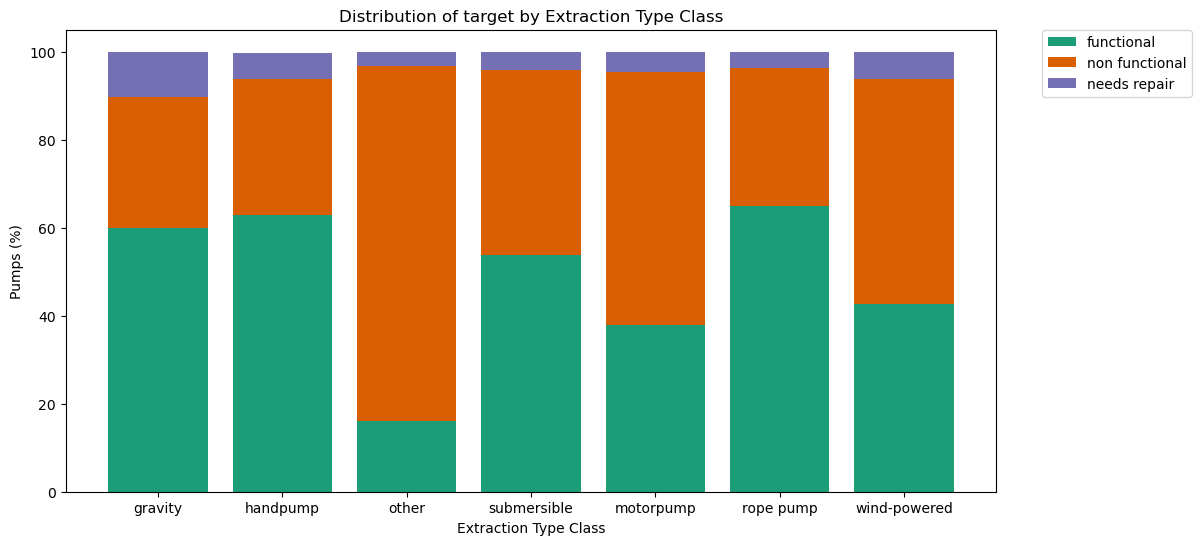

In [377]:
# Whatever is in the "other" category seems to be mostly non-functional
fig, ax = plt.subplots(figsize=(12,6))
labels = labels = extraction_class.index
ax.bar(labels, extraction_class['perc_functional'], label='functional',  color = hex_codes[0])
ax.bar (labels, extraction_class['perc_non_functional'], label = 'non functional', bottom = extraction_class['perc_functional'] , color = hex_codes[1])
ax.bar(labels, extraction_class['perc_functional_needs_repair'], label = 'needs repair', bottom = extraction_class['perc_functional'] + extraction_class['perc_non_functional'],  color = hex_codes[2])
ax.set(title = 'Distribution of target by Extraction Type Class', xlabel = 'Extraction Type Class', ylabel = 'Pumps (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### **payment and payment_type**

In [378]:
# Overview
categorical_dqr.loc[['payment', 'payment_type']]

,Data Type,Records,Unique Values,Missing Values,Missing %,Mode,Mode freq.,Mode %
payment,object,59400,7,0,0.0,never pay,25348,42.7
payment_type,object,59400,7,0,0.0,never pay,25348,42.7


In [379]:
# Seemingly the same information contained in these features, just labelled differently
df[['payment', 'payment_type']].sample(10)

,payment,payment_type
1475,pay annually,annually
24732,pay monthly,monthly
53869,never pay,never pay
45035,pay monthly,monthly
18945,pay monthly,monthly
51766,pay annually,annually
33112,pay monthly,monthly
54019,other,other
54005,never pay,never pay
43162,pay per bucket,per bucket


In [380]:
df['payment'].value_counts()

payment
never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: count, dtype: int64

In [381]:
df['payment_type'].value_counts()

payment_type
never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: count, dtype: int64

Indeed, these two categories contain the exact same information, only slight variation in the labelling (pay per bucket vs per bucket). Only one of these two will be used in the modelling phase.

In [382]:
# Quick look at the distribution of the target variable among 'payment'
distribution_checker(df, 'payment_type').sort_values('nr_pumps', ascending=False)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
payment_type,,,,,
never pay,25348.0,42.7,44.9,47.6,7.5
per bucket,8985.0,15.1,67.8,27.7,4.6
monthly,8300.0,14.0,66.0,22.8,11.2
unknown,8157.0,13.7,43.3,51.5,5.3
on failure,3914.0,6.6,62.1,30.9,7.1
annually,3642.0,6.1,75.2,18.0,6.8
other,1054.0,1.8,58.0,30.8,11.2


### **water_quality and quality_group**

Perhaps another case of less granular to more granular feature?

In [383]:
# Overview
categorical_dqr.loc[['water_quality', 'quality_group']]

,Data Type,Records,Unique Values,Missing Values,Missing %,Mode,Mode freq.,Mode %
water_quality,object,59400,8,0,0.0,soft,50818,85.6
quality_group,object,59400,6,0,0.0,good,50818,85.6


In [384]:
# 'quality_group' seems to be a more general version of 'water_quality'
distribution_checker(df, 'quality_group').sort_values('nr_pumps', ascending=False)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
quality_group,,,,,
good,50818.0,85.6,56.6,35.7,7.7
salty,5195.0,8.7,46.1,48.2,5.7
unknown,1876.0,3.2,14.1,84.1,1.9
milky,804.0,1.4,54.5,43.8,1.7
colored,490.0,0.8,50.2,38.8,11.0
fluoride,217.0,0.4,72.4,21.7,6.0


In [385]:
distribution_checker(df, 'water_quality').sort_values('nr_pumps', ascending=False)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
water_quality,,,,,
soft,50818.0,85.6,56.6,35.7,7.7
salty,4856.0,8.2,45.7,49.6,4.6
unknown,1876.0,3.2,14.1,84.1,1.9
milky,804.0,1.4,54.5,43.8,1.7
coloured,490.0,0.8,50.2,38.8,11.0
salty abandoned,339.0,0.6,51.3,27.4,21.2
fluoride,200.0,0.3,75.5,18.0,6.5
fluoride abandoned,17.0,0.0,35.3,64.7,0.0


'quality_group' is indeed a less granular version of 'water_quality'. For my analysis, I'll be using the less granular 'quality_group'.

### **source, source_type, source_class**

Source of water from less granularity to more granularity perhaps?

In [386]:
# Overview
categorical_dqr.loc[['source', 'source_type', 'source_class']]

,Data Type,Records,Unique Values,Missing Values,Missing %,Mode,Mode freq.,Mode %
source,object,59400,10,0,0.0,spring,17021,28.7
source_type,object,59400,7,0,0.0,spring,17021,28.7
source_class,object,59400,3,0,0.0,groundwater,45794,77.1


In [387]:
# Distribution of target variable among 'source_class'
distribution_checker(df, 'source_class').sort_values('nr_pumps', ascending=False)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
source_class,,,,,
groundwater,45794.0,77.1,54.2,39.8,6.0
surface,13328.0,22.4,54.5,33.7,11.8
unknown,278.0,0.5,56.8,41.4,1.8


In [388]:
# Distribution of target variable among 'source_type'
distribution_checker(df, 'source_type').sort_values('nr_pumps', ascending=False)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
source_type,,,,,
spring,17021.0,28.7,62.2,30.3,7.5
shallow well,16824.0,28.3,49.5,44.8,5.7
borehole,11949.0,20.1,49.5,46.2,4.3
river/lake,10377.0,17.5,54.2,33.9,11.9
rainwater harvesting,2295.0,3.9,60.4,25.9,13.7
dam,656.0,1.1,38.6,57.8,3.7
other,278.0,0.5,56.8,41.4,1.8


In [389]:
# Distribution of target variable among 'source'
distribution_checker(df, 'source').sort_values('nr_pumps', ascending=False)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
source,,,,,
spring,17021.0,28.7,62.2,30.3,7.5
shallow well,16824.0,28.3,49.5,44.8,5.7
machine dbh,11075.0,18.6,49.0,46.6,4.4
river,9612.0,16.2,56.9,30.4,12.7
rainwater harvesting,2295.0,3.9,60.4,25.9,13.7
hand dtw,874.0,1.5,56.9,41.2,1.9
lake,765.0,1.3,21.2,77.3,1.6
dam,656.0,1.1,38.6,57.8,3.7
other,212.0,0.4,59.4,40.1,0.5


'source_class' is the highest level of these categories and breaks down into more granularity in 'source_type' and even more in 'source'. Water points where spring or rainwater harvesting is the source seem to have more functional pumps. Perhaps the most granular of these is the one worth keeping for classification purposes.

### **waterpoint_type, waterpoint_type_group**

In [390]:
# Overview
categorical_dqr.loc[['waterpoint_type', 'waterpoint_type_group']]

,Data Type,Records,Unique Values,Missing Values,Missing %,Mode,Mode freq.,Mode %
waterpoint_type,object,59400,7,0,0.0,communal standpipe,28522,48.0
waterpoint_type_group,object,59400,6,0,0.0,communal standpipe,34625,58.3


These two seem to contain similar information.

In [391]:
# Distribution of target variable among 'waterpoint_type_group'
distribution_checker(df, 'waterpoint_type_group').sort_values('nr_pumps', ascending=False)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
waterpoint_type_group,,,,,
communal standpipe,34625.0,58.3,57.6,34.0,8.4
hand pump,17488.0,29.4,61.8,32.3,5.9
other,6380.0,10.7,13.2,82.2,4.6
improved spring,784.0,1.3,71.8,17.3,10.8
cattle trough,116.0,0.2,72.4,25.9,1.7
dam,7.0,0.0,85.7,14.3,0.0


In [392]:
# Distribution of target variable among 'waterpoint_type'
distribution_checker(df, 'waterpoint_type').sort_values('nr_pumps', ascending=False)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
waterpoint_type,,,,,
communal standpipe,28522.0,48.0,62.1,29.9,7.9
hand pump,17488.0,29.4,61.8,32.3,5.9
other,6380.0,10.7,13.2,82.2,4.6
communal standpipe multiple,6103.0,10.3,36.6,52.8,10.6
improved spring,784.0,1.3,71.8,17.3,10.8
cattle trough,116.0,0.2,72.4,25.9,1.7
dam,7.0,0.0,85.7,14.3,0.0


The only difference is that 'waterpoint_type' breaks the communal standpipe class into communal standpipe and communal standpipe multiple. Communal standpipe multiple type water points seemingly have lower functionality. The slightly increased granularity here might give us a better picture when doing classification.

In [393]:
# Export full training dataset as csv
df.to_csv('../data/processed/training_set_full.csv', index=False)

In [394]:
# Export test dataset as csv
df_test.to_csv('../data/processed/test_set.csv', index=False)